# Overview

The objective of this code is to generate the sequence of signals (-1, 0, 1) that represent an investment strategy. Those signals are indicative of a recommendation to either decrease, maintain or increase portfolio allocations to equity.

The signals are the output classification of a random forest model that is trained to classify next-period S&P returns above, between or below a certain threshold. 

The inspiration of this model, and the features utilized come from the work of Nikolaos Panigirtzoglou (2019) through his recurring publications 'Flows and Liqudity' for JPMorgan.

# Setup

In [ ]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from datetime import datetime, timedelta
from math import pi

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# required to run on Google's collaboratory
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 4.5 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
#utility function to calculate a zscore of a given time-series
def zscore(x, window = 104):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

## Loading up Data

In [ ]:
path = 'PATH_TO_DATA'

### Positions

This section requires the aggregated information obtained from the Website of the Commodity Futures Trading Comission (CFTC).

As downloaded from:

https://www.cftc.gov/MarketReports/CommitmentsofTraders/HistoricalCompressed/index.htm

In a file available in the repository (CFTC_COT_FUTURES.xls) the aggregated history of 'Traders in Financial Futures ; Futures Only Reports:." is condensed for ease of loading. 

This feature is constructed by calculating the difference of net long positions of 'open interest' between futures on S&P (both large and mini) and futures on 10-year treasury notes.

It considers open interest from 'Asset Managers' and 'Leveraged Money' for S&P and 'Dealers' and 'Other' for Treasuries. These are considered to be 'speculative' in nature, and so relevant for the analysis.

For details see Panigirtzoglou 2019.

In [ ]:
archivo = path + 'CFTC_COT_FUTURESv3.xls'
positions = pd.read_excel(archivo)

positions['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(positions['Report_Date_as_MM_DD_YYYY'], format = '%m/%d/%Y') 

snpb = positions[positions.Market_and_Exchange_Names == 'S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE']
snpm = positions[positions.Market_and_Exchange_Names == 'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE']

weights = pd.merge(snpb[['Report_Date_as_MM_DD_YYYY', 'Open_Interest_All']], snpm[['Report_Date_as_MM_DD_YYYY', 'Open_Interest_All']], how = 'outer', on = 'Report_Date_as_MM_DD_YYYY')
weights['Open_Interest_All_x'] = weights.Open_Interest_All_x
weights['Open_Interest_All_y'] = weights.Open_Interest_All_y
weights = weights.fillna(0)
weights['Open_Interest_Total'] = weights.Open_Interest_All_x + weights.Open_Interest_All_y
weights['Open_Interest_All_x'] = weights.Open_Interest_All_x/weights.Open_Interest_Total
weights['Open_Interest_All_y'] = weights.Open_Interest_All_y/weights.Open_Interest_Total
weights.columns = ['DATE', 'wSNPB', 'wSNPM', 'OI_Total']

In [ ]:
snpb = snpb[['Report_Date_as_MM_DD_YYYY','Market_and_Exchange_Names', 'Open_Interest_All', 'Pct_of_OI_Asset_Mgr_Long_All', 'Pct_of_OI_Asset_Mgr_Short_All', 'Pct_of_OI_Lev_Money_Long_All', 'Pct_of_OI_Lev_Money_Short_All']]

# only relevant types of investors considered
snpb['Pct_of_OI_Net_Long_All_EQY'] = snpb.Pct_of_OI_Asset_Mgr_Long_All - snpb.Pct_of_OI_Asset_Mgr_Short_All + snpb.Pct_of_OI_Lev_Money_Long_All - snpb.Pct_of_OI_Lev_Money_Short_All
snpb = snpb[['Report_Date_as_MM_DD_YYYY', 'Pct_of_OI_Net_Long_All_EQY']]
snpb.columns = ['DATE', 'Pct_of_OI_Net_Long_SNPB']
snpb = snpb.sort_values(by = 'DATE')

snpm = snpm[['Report_Date_as_MM_DD_YYYY','Market_and_Exchange_Names', 'Open_Interest_All', 'Pct_of_OI_Asset_Mgr_Long_All', 'Pct_of_OI_Asset_Mgr_Short_All', 'Pct_of_OI_Lev_Money_Long_All', 'Pct_of_OI_Lev_Money_Short_All']]

# only relevant types of investors considered
snpm['Pct_of_OI_Net_Long_All_EQY'] = snpm.Pct_of_OI_Asset_Mgr_Long_All - snpm.Pct_of_OI_Asset_Mgr_Short_All + snpm.Pct_of_OI_Lev_Money_Long_All - snpm.Pct_of_OI_Lev_Money_Short_All
snpm = snpm[['Report_Date_as_MM_DD_YYYY', 'Pct_of_OI_Net_Long_All_EQY']]
snpm.columns = ['DATE', 'Pct_of_OI_Net_Long_SNPM']
snpm = snpm.sort_values(by = 'DATE')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
equity = pd.merge(snpb, snpm, how = 'outer', on = 'DATE').fillna(0)
equity = pd.merge(equity, weights, how = 'outer', on = 'DATE')
equity['Pct_of_OI_Net_Long_All_EQY'] = equity.Pct_of_OI_Net_Long_SNPB*equity.wSNPB + equity.Pct_of_OI_Net_Long_SNPM*equity.wSNPM
equity = equity[['DATE', 'Pct_of_OI_Net_Long_All_EQY']]

In [ ]:
try10 = positions[positions.Market_and_Exchange_Names == '10-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE']
trys = try10

trys = trys[['Report_Date_as_MM_DD_YYYY','Market_and_Exchange_Names', 'Open_Interest_All', 'Pct_of_OI_Dealer_Long_All', 'Pct_of_OI_Dealer_Short_All', 'Pct_of_OI_Other_Rept_Long_All', 'Pct_of_OI_Other_Rept_Short_All']]

# only relevant types of investors considered
trys['Pct_of_OI_Net_Long_All_TSY'] = trys.Pct_of_OI_Dealer_Long_All - trys.Pct_of_OI_Dealer_Short_All + trys.Pct_of_OI_Other_Rept_Long_All - trys.Pct_of_OI_Other_Rept_Short_All

trys = trys[['Report_Date_as_MM_DD_YYYY', 'Pct_of_OI_Net_Long_All_TSY']]
trys.columns = ['DATE', 'Pct_of_OI_Net_Long_All_TSY']

positions_both = pd.merge(equity, trys, on = 'DATE', how = 'outer')
positions_both['Net_Long'] = positions_both.Pct_of_OI_Net_Long_All_EQY - positions_both.Pct_of_OI_Net_Long_All_TSY
positions_both = positions_both.set_index('DATE')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
positions_both.loc['2019-09-24', 'Net_Long'] = 20 #fixing corrupted number on the database, replaced by simple linear interpolation
positions_both.loc['2019-12-24', 'Net_Long'] = 26 #fixing corrupted number on the database, replaced by simple linear interpolation
positions_both = positions_both.sort_values(by = 'DATE')

### Flows

In [ ]:
# raw data obtained from Bloomberg: data tickers as in the cell below
flows = pd.read_csv(path + 'flows.csv')

In [ ]:
flows = flows.rename({'NNCFTEEW Index': 'EQUITY_FUNDS', 'NNCFTBEW Index': 'BOND_FUNDS', 'WETFTTEF Index': 'EQUITY_ETFS' , 'WETFTTBD Index': 'BOND_ETFS'}, axis = 1)
flows = flows.fillna(0)
flows['NET_FLOW'] = flows.EQUITY_ETFS + flows.EQUITY_FUNDS - flows.BOND_ETFS - flows.BOND_FUNDS

In [ ]:
flows['DATE'] = pd.to_datetime(flows.DATE)
flows = flows.set_index('DATE')

### Momentum

In [ ]:
# raw data obtained from Bloomberg: contains 6month total return of the S&P
spy = pd.read_csv(path + 'momentum.csv')

In [ ]:
spy['DATE'] = pd.to_datetime(spy.DATE)
spy = spy.set_index('DATE')

### Economic Momentum

In [ ]:
# raw data obtained from Bloomberg: contains Markit Global Manufacturing PMI levels
archivo = path + 'MARKIT_GLOBAL_PMI.xlsx'
pmis = pd.read_excel(archivo, engine = 'openpyxl')
pmis = pmis.iloc[1:,[0,-1]]
pmis.columns = ['DATE', 'PMI_MANUFACTURE']
pmis = pmis.set_index('DATE')

### Value

In [ ]:
# raw data obtained from Bloomberg: contains US 10-year real yield and the inverse (1/x) of S&P 12-month forward (Bloomberg Estimates, BEst) Price/Earnings
spy_best_yield = pd.read_csv(path + 'spy_best_yield.csv')
ust10 = pd.read_csv(path + 'ust10.csv')

In [ ]:
eyg = pd.merge(spy_best_yield, ust10, on = 'DATE', how = 'outer')
eyg['EYG'] = eyg.SPY_YIELD - eyg.TRY_YIELD

In [ ]:
eyg['DATE'] = pd.to_datetime(eyg.DATE)
eyg = eyg.set_index('DATE')
eyg.tail()

,SPY_YIELD,TRY_YIELD,EYG
DATE,,,
2022-02-18,5.246837,-0.5137,5.760537
2022-02-25,5.215069,-0.5993,5.814369
2022-03-04,5.302986,-0.9716,6.274586
2022-03-11,5.498372,-0.9830,6.481372
2022-03-18,5.201317,-0.7554,5.956717


## Data Manipulation

In [ ]:
# Positions
# 52-week zscore
positions_score = zscore(-positions_both.Net_Long.sort_index(), 52)

# Value
# 52-week zscore
value_score = zscore(eyg.EYG, 52)

# Economic Momentum
# 24 month zscore of 2-month changes 
economic_score = zscore((pmis.PMI_MANUFACTURE - pmis.PMI_MANUFACTURE.shift(2)), 24)

# Flows (see Panigirtzoglou, 2019)
# corresponds to the 
# 1. 52-week zscore
# 2. of the 1-week change in the trend component (as obtained by a Hodrik Prescott filter with lambda = 100) 
# 3. of the 4-week rolling average of net flows
flows_mean = flows.NET_FLOW.rolling(4).mean().dropna()
flows_cycle, flows_trend = sm.tsa.filters.hpfilter(flows_mean, 100)
flows_score = zscore(flows_trend - flows_trend.shift(1), 52)

#Price Momentum
# 365-day zscore of 6month price momentum
price_score = zscore(spy.SPX/spy.SPX.shift(183) - 1, 365)

#Price Reversal
# 365-day zscore of 1month price momentum (with a negative sign to account for the intuition that this signal should contribute in an inverse fashion to the momentum one)
reversal_score = zscore(-(spy.SPX/spy.SPX.shift(30) - 1), 365)


## Feature Construction

In [ ]:
raw_signals = pd.concat([positions_score, value_score, economic_score, flows_score, price_score, reversal_score], axis = 1)
raw_signals.columns = ['position', 'value', 'economic', 'flow', 'price', 'reversal']
raw_signals = raw_signals.fillna(method = 'ffill').fillna(0)

## Label Construction

In [ ]:
# Labels are calculated 

# 1 day returns forward are first obtained
fwd_returns_1d = (spy.SPX.shift(-1)/spy.SPX-1)

# then the rolling maximum of forward 30-day return is obtained, and the check is made to verify if the excess threshold is exceeded 
# this in effect constitutes a label, if the threshold is exceeded it contains a 'True' value, a False if not
labels_pos = fwd_returns_1d.rolling(30).aggregate(lambda x: x.cumsum().max()).shift(-30) > 0.03 #threshold of 3%

# resampled to monthly frequency by filling forward in case needed
labels_pos = labels_pos.resample('M').pad()

# the same is done but for the negative threshold, and using the minimum of forward 30-day returns
labels_neg = fwd_returns_1d.rolling(30).aggregate(lambda x: x.cumsum().min()).shift(-30) < -0.03
labels_neg = labels_neg.resample('M').pad()

# index of day within the month in which the maximum and minimum occurs is obtained
labels_pos_idx = fwd_returns_1d.rolling(30).aggregate(lambda x: int((x.cumsum()).idxmax().strftime('%Y%m%d'))).shift(-30)
labels_pos_idx = labels_pos_idx.resample('M').pad()
labels_neg_idx = fwd_returns_1d.rolling(30).aggregate(lambda x: int(((-x).cumsum()).idxmax().strftime('%Y%m%d'))).shift(-30)
labels_neg_idx = labels_neg_idx.resample('M').pad()

# for those months which could be labeled both True and False, we check which happens first 
# by relying on whether the minimum happened first (or viceversa) by using the index of the days in which the minimum (or maximum) ocurred
up_first = labels_neg_idx[labels_neg & labels_pos] > labels_pos_idx[labels_neg & labels_pos]

# the label for those months in which need a correction is calculated
both_correction = 1*up_first + -1*~up_first

# the label is constrcuted, -1 for negative months, +1 for positive months
labels_tot = -1*labels_neg + 1*labels_pos

# but corrected for first ocurrence for those days which have both labels
labels_tot.loc[both_correction.index] = both_correction

labels_tot.name = 'labels'
labels_1mo = labels_tot.loc['2008-01-31':'2016-06-30']

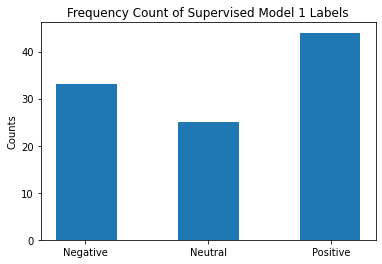

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

n, bins, patches = plt.hist(labels_1mo, 3, rwidth = 0.5, label = [-1, 0, 1])

plt.xticks([-0.675, 0, 0.675], ["Negative", "Neutral", "Positive"])
plt.title('Frequency Count of Supervised Model 1 Labels')
plt.ylabel('Counts');

## Specification of In Sample Signals

In [ ]:
signals = raw_signals.loc['2008-01-30':'2016-06-30']
signals = signals.resample('M').pad()

## Decision Tree

In [ ]:
# Random Forest classifier with mostly default parameters
# only max_depth = 4, and n_estimators were changed

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', 
                              max_depth=4, max_features='auto', max_leaf_nodes=None,
                              min_impurity_decrease=0.0, 
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
                              oob_score=False, random_state=0, verbose=0, warm_start=False)
clf.fit(signals, labels_1mo)

# feature importances displayed 
print(clf.feature_importances_)

[0.11927816 0.22973411 0.18393934 0.11665367 0.17025773 0.180137  ]


In [ ]:
# in sample accuracy metrics calculated

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 

test = clf.predict(signals)
print(confusion_matrix(labels_1mo,test))
print(classification_report(labels_1mo,test))  
print(accuracy_score(labels_1mo,test))

[[29  1  3]
 [ 0 22  3]
 [ 1  0 43]]
              precision    recall  f1-score   support

          -1       0.97      0.88      0.92        33
           0       0.96      0.88      0.92        25
           1       0.88      0.98      0.92        44

    accuracy                           0.92       102
   macro avg       0.93      0.91      0.92       102
weighted avg       0.93      0.92      0.92       102

0.9215686274509803


In [ ]:
# out of sample accuracy metrics calculated

signals = raw_signals.loc['2016-06-30':'2020-12-31']
signals = signals.resample('M').pad()
labels_1mo = labels_tot.loc['2016-06-30':'2020-12-31']

test = clf.predict(signals)
print(confusion_matrix(labels_1mo,test))
print(classification_report(labels_1mo,test))  
print(accuracy_score(labels_1mo,test))

[[ 2  0  5]
 [ 6  6 12]
 [ 6  3 15]]
              precision    recall  f1-score   support

          -1       0.14      0.29      0.19         7
           0       0.67      0.25      0.36        24
           1       0.47      0.62      0.54        24

    accuracy                           0.42        55
   macro avg       0.43      0.39      0.36        55
weighted avg       0.51      0.42      0.42        55

0.41818181818181815


## Output Plots

### Evolution of Probabilities and Last Probability Graphs

In [ ]:
signals = raw_signals.loc['2016-06-30':]
signals = signals.resample('W').pad()

test = clf.predict(signals)
test_prob = clf.predict_proba(signals)
test_prob = pd.DataFrame.from_dict(dict(zip(signals.index, test_prob)), orient = 'index')
test_prob.columns = ['neg', 'neu', 'pos']

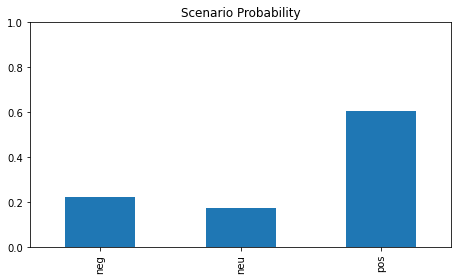

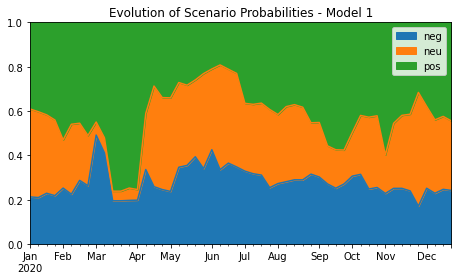

In [ ]:
fig00, ax00 = plt.subplots(1,1, figsize=(6.47,4))
test_prob.iloc[-1].plot.bar(ax = ax00, title = f'Scenario Probability')
plt.ylim(0,1)
plt.tight_layout()

fig0, ax0 = plt.subplots(1,1, figsize=(6.47,4))
title = 'Evolution of Scenario Probabilities - Model 1'
test_prob.loc['2020'].plot.area(ax=ax0, title=title)

plt.ylim(0,1)
plt.tight_layout()

### Market Health Spider Chart

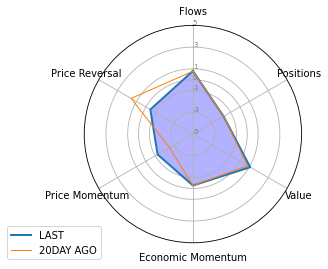

In [ ]:
# Last features plotted for interpretation purposes

df = pd.DataFrame({
'group': ['NOW','1MO'],
'Flows': [raw_signals['flow'][-1], raw_signals['flow'][-20]],
'Positions': [raw_signals['position'][-1], raw_signals['position'][-20]],
'Value': [raw_signals['value'][-1], raw_signals['value'][-20]],
'Economic Momentum': [raw_signals['economic'][-1], raw_signals['economic'][-20]],
'Price Momentum': [raw_signals['price'][-1], raw_signals['price'][-20]],
    'Price Reversal': [raw_signals['reversal'][-1], raw_signals['reversal'][-20]]
})

# ------- PART 1: Create background

# number of variable
categories = list(df.drop('group', axis = 1))
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-5, -3, -1, 0, 1, 3, 5], ["-5", "-3", "-1", "0", "1", "3", "5"], color="grey", size=7)
plt.ylim(-5, 5)

# ------- PART 2: Add plots

# Ind1
values = df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"LAST")
ax.fill(angles, values, 'b', alpha=0.3)

# Ind2
values = df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="20DAY AGO")
ax.fill(angles, values, 'r', alpha=0)


# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Strategy Output

Output for testing period saved in a separate file to load up on the MAB code

In [ ]:
signals = raw_signals.loc['2016-06-30':]
signals = signals.resample('W-FRI').pad() 

model_output = clf.predict(signals)

In [ ]:
recommendation = pd.DataFrame.from_dict(dict(zip(signals.index, model_output)), orient = 'index')
recommendation.columns = ['signal']

In [ ]:
recommendation.to_csv('/content/drive/Shareddrives/Capstone Project/Data/supervisedmodel1.csv', sep='\t', encoding='utf-8', index=True)